# 📘 Notebook 3 — Model Estimation and Comparison (Econometric + ML Models)

This notebook extends the feature-engineered dataset from **Notebook 2** to estimate, evaluate, and compare two major modeling frameworks for forecasting hotel demand across EU countries (2015–2025):

- **Part 1 — Econometric Models:** ARIMAX and SARIMAX, focusing on macroeconomic and seasonal patterns.
- **Part 2 — Machine Learning Models:** XGBoost and LightGBM, trained on feature-engineered datasets for predictive accuracy and SHAP-based interpretability.

---

### **Structure Overview**

0. Environment Setup  
1. Load Data & Split  

**Part 1 — Econometric Modeling (ARIMAX, SARIMAX)**  
2. Naive Forecast (Last Month = Prediction)  
3. ARIMAX Forecast (Per Region)  
4. SARIMAX Forecast (Per Region)  
5. Econometric Model Performance Summary & Visualization  
6. Comparison: ARIMAX vs SARIMAX (Top 5 EU Countries)  

**Part 2 — Machine Learning Models (XGBoost + LightGBM)**  
7. Global ML Models (XGB & LGBM)  
8. Save Master Predictions  
9. ML Model Performance Summary & Visualization  
10. Visualize XGBoost and LightGBM Forecasts — Top 5 Countries  
11. Save Transformed SHAP Matrix (for XGB/LGBM)  

---

**Input:**  
📁 `../data/processed/hotel_features.csv`

**Output:**  
📁 `../data/processed/hotel_predictions.csv`  
📁 `../outputs/models/arimax/arimax_<region>.pkl`  
📁 `../outputs/models/sarimax/sarimax_<region>.pkl`  
📁 `../outputs/models/pipe_xgb.pkl`, `pipe_lgbm.pkl`  
📁 `../outputs/models/lgbm/lgbm_<region>.pkl`

In [1]:
# %% ===============================================================
# STEP 0 — ENVIRONMENT SETUP
# ===============================================================

import sys
from pathlib import Path
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import joblib
import json
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from utils.metrics import rmse, mae, mape
from utils.modeling import (
    train_global_pipeline,
    predict_with_pipeline,
    train_region_lgbm_and_dump
)
from utils.plots import compare_econometric_models, compare_ml_models

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")
warnings.filterwarnings("ignore")

BASE_DIR = Path("..")
DATA_PROCESSED = BASE_DIR / "data" / "processed"
OUTPUTS = BASE_DIR / "outputs"
FIGURES = OUTPUTS / "figures"
MODELS = OUTPUTS / "models"
MODELS_ARIMAX = MODELS / "arimax"
MODELS_SARIMAX = MODELS / "sarimax"
REPORTS = OUTPUTS / "reports"

for path in [DATA_PROCESSED, FIGURES, MODELS, MODELS_ARIMAX, MODELS_SARIMAX, REPORTS]:
    path.mkdir(parents=True, exist_ok=True)

print("✅ Environment setup complete.")

✅ Environment setup complete.


In [2]:
# %% ===============================================================
# STEP 1 — LOAD DATA & SPLIT
# Purpose: read engineered features and split into train/valid (2024)
# ===============================================================

FEATURE_PATH = DATA_PROCESSED / "hotel_features.csv"

df = pd.read_csv(FEATURE_PATH, parse_dates=["month"])
df = df.sort_values(["region", "month"]).reset_index(drop=True)
print(f"✅ Loaded dataset with shape: {df.shape}")

target = "log_nights_spent"
cat_cols = ["region"]
num_cols = [c for c in df.columns if c not in ["region","month",target] and df[c].dtype != "O"]

train = df[df["month"] < "2024-01-01"].copy()
valid = df[(df["month"] >= "2024-01-01") & (df["month"] < "2025-01-01")].copy()

print(f"✅ Dataset: {df.shape}, Train: {train.shape}, Valid: {valid.shape}")

✅ Loaded dataset with shape: (3328, 30)
✅ Dataset: (3328, 30), Train: (2808, 30), Valid: (312, 30)


In [3]:
# %% ===============================================================
# PART 1 — ECONOMETRIC MODELING (ARIMAX, SARIMAX)
# ===============================================================


# %% ===============================================================
# STEP 2 — NAIVE FORECAST
# Purpose: last month = prediction (per region)
# ===============================================================

df["yhat_naive"] = df.groupby("region")[target].shift(1)

# Check that it aligns with split boundaries
print("✅ Added naive baseline (lag-1). Example tail:")
display(df.groupby("region").tail(3)[["region", "month", target, "yhat_naive"]].head(10))

✅ Added naive baseline (lag-1). Example tail:


,region,month,log_nights_spent,yhat_naive
125,AT,2025-06-30,14.698787,14.555365
126,AT,2025-07-31,14.821111,14.698787
127,AT,2025-08-31,14.942146,14.821111
253,BE,2025-06-30,13.557848,13.561620
254,BE,2025-07-31,13.634188,13.557848
255,BE,2025-08-31,13.618875,13.634188
381,BG,2025-06-30,13.831692,13.469083
382,BG,2025-07-31,14.341255,13.831692
383,BG,2025-08-31,14.383078,14.341255
509,CY,2025-06-30,11.762392,11.225910


In [4]:
# %% ===============================================================
# STEP 3 — ARIMAX FORECAST (PER REGION)
# Purpose: fit non-seasonal ARIMAX with classic macro exog; dump models
# ===============================================================

arimax_exog = ["log_gdp", "unemployment_rate", "turnover_index", "weighted_stringency_index"]
preds_arimax = []

for region, dfc in tqdm(df.groupby("region"), desc="Fitting ARIMAX by region"):
    dfc = dfc.sort_values("month").dropna(subset=[target]).set_index("month")
    valid_exog = [c for c in arimax_exog if c in dfc and dfc[c].notna().sum() > 24]
    if len(valid_exog) < len(arimax_exog) or len(dfc) < 36:
        continue
    dfc[valid_exog] = dfc[valid_exog].ffill().bfill()
    try:
        model = SARIMAX(
            dfc[target], exog=dfc[valid_exog],
            order=(1,0,1), enforce_stationarity=True, enforce_invertibility=True
        ).fit(disp=False, maxiter=500)

        warmup = min(12, max(0, len(dfc)-1))
        start_idx = dfc.index[warmup] if len(dfc) > warmup else dfc.index[0]
        dfc["yhat_arimax"] = model.get_prediction(
            start=start_idx, end=dfc.index[-1], exog=dfc.loc[start_idx:, valid_exog]
        ).predicted_mean

        preds_arimax.append(dfc.reset_index()[["region","month","yhat_arimax"]])
        joblib.dump(model, MODELS_ARIMAX / f"arimax_{region}.pkl")
    except Exception as e:
        print(f"[WARN] {region}: {e}")

if preds_arimax:
    arim = pd.concat(preds_arimax, ignore_index=True).drop_duplicates(["region","month"])
    df = df.drop(columns=["yhat_arimax"], errors="ignore").merge(arim, on=["region","month"], how="left")

    base_path = DATA_PROCESSED / "hotel_predictions.csv"
    if base_path.exists():
        base = pd.read_csv(base_path, parse_dates=["month"])
        base = base.drop(columns=["yhat_arimax"], errors="ignore").merge(arim, on=["region","month"], how="left")
    else:
        base = df.copy()
    base.to_csv(base_path, index=False)
    print(f"✅ ARIMAX forecasts saved to {base_path} — {base.shape[0]} rows.")
else:
    print("⚠️ No ARIMAX results generated.")

Fitting ARIMAX by region: 100%|██████████| 26/26 [00:03<00:00,  8.03it/s]

✅ ARIMAX forecasts saved to ../data/processed/hotel_predictions.csv — 3328 rows.


In [5]:
# %% ===============================================================
# STEP 4 — SARIMAX FORECAST (PER REGION)
# Purpose: fit seasonal ARIMAX with dynamic exog; dump models
# ===============================================================

exog_vars = [
    "log_gdp_mom","turnover_index_mom",
    "log_gdp_lag1","log_gdp_lag2","log_gdp_lag3",
    "unemployment_rate_lag1","unemployment_rate_lag2","unemployment_rate_lag3",
    "turnover_index_lag1","turnover_index_lag2","turnover_index_lag3",
    "weighted_stringency_index_lag1","weighted_stringency_index_lag2",
    "eurusd_lag1","eurusd_lag2","eurgbp_lag1"
]
preds_sarimax = []

for region, dfc in tqdm(df.groupby("region"), desc="Fitting SARIMAX by region"):
    dfc = dfc.sort_values("month").dropna(subset=[target]).set_index("month")
    valid_exog = [c for c in exog_vars if c in dfc and dfc[c].notna().sum() > 24]
    if len(valid_exog) == 0 or len(dfc) < 36: 
        continue
    dfc[valid_exog] = dfc[valid_exog].ffill().bfill()
    try:
        model = SARIMAX(
            dfc[target], exog=dfc[valid_exog],
            order=(1,0,1), seasonal_order=(1,1,1,12),
            enforce_stationarity=True, enforce_invertibility=True
        ).fit(disp=False, maxiter=500)

        warmup = min(12, max(0, len(dfc)-1))
        start_idx = dfc.index[warmup] if len(dfc) > warmup else dfc.index[0]
        dfc["yhat_sarimax"] = model.get_prediction(
            start=start_idx, end=dfc.index[-1], exog=dfc.loc[start_idx:, valid_exog]
        ).predicted_mean

        preds_sarimax.append(dfc.reset_index()[["region","month","yhat_sarimax"]])
        joblib.dump(model, MODELS_SARIMAX / f"sarimax_{region}.pkl")
    except Exception as e:
        print(f"[WARN] {region}: {e}")

if preds_sarimax:
    sari = pd.concat(preds_sarimax, ignore_index=True).drop_duplicates(["region","month"])
    df = df.drop(columns=["yhat_sarimax"], errors="ignore").merge(sari, on=["region","month"], how="left")

    base_path = DATA_PROCESSED / "hotel_predictions.csv"
    if base_path.exists():
        base = pd.read_csv(base_path, parse_dates=["month"])
        base = base.drop(columns=["yhat_sarimax"], errors="ignore").merge(sari, on=["region","month"], how="left")
    else:
        base = df.copy()
    base.to_csv(base_path, index=False)
    print(f"✅ SARIMAX forecasts saved to {base_path} — {base.shape[0]} rows.")
else:
    print("⚠️ No SARIMAX results generated.")

Fitting SARIMAX by region: 100%|██████████| 26/26 [04:05<00:00,  9.46s/it]

✅ SARIMAX forecasts saved to ../data/processed/hotel_predictions.csv — 3328 rows.


📊 Mean RMSE / MAE / MAPE across all regions:
 RMSE_ARIMAX     0.303
MAE_ARIMAX      0.184
MAPE_ARIMAX     1.501
RMSE_SARIMAX    0.220
MAE_SARIMAX     0.147
MAPE_SARIMAX    1.197
dtype: float64


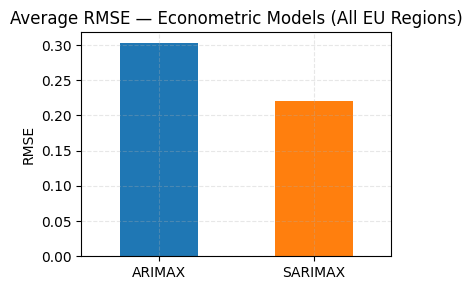

In [6]:
# %% ===============================================================
# STEP 5 — ECONOMETRIC MODEL PERFORMANCE SUMMARY & VISUALIZATION
# Purpose: Summarize ARIMAX vs SARIMAX using RMSE / MAE / MAPE and visualize results
# ===============================================================

# --- Compute per-region metrics using shared functions ---
res_econometric = (
    df.dropna(subset=["yhat_arimax", "yhat_sarimax", "log_nights_spent"])
      .groupby("region", group_keys=False)
      .apply(lambda d: pd.Series({
          "RMSE_ARIMAX": rmse(d["log_nights_spent"], d["yhat_arimax"]),
          "MAE_ARIMAX":  mae(d["log_nights_spent"], d["yhat_arimax"]),
          "MAPE_ARIMAX": mape(d["log_nights_spent"], d["yhat_arimax"]),
          "RMSE_SARIMAX": rmse(d["log_nights_spent"], d["yhat_sarimax"]),
          "MAE_SARIMAX":  mae(d["log_nights_spent"], d["yhat_sarimax"]),
          "MAPE_SARIMAX": mape(d["log_nights_spent"], d["yhat_sarimax"]),
      }))
      .reset_index()
)

# --- Mean performance across all regions ---
mean_metrics_econ = res_econometric[[
    "RMSE_ARIMAX", "MAE_ARIMAX", "MAPE_ARIMAX",
    "RMSE_SARIMAX", "MAE_SARIMAX", "MAPE_SARIMAX"
]].mean().round(3)

print("📊 Mean RMSE / MAE / MAPE across all regions:\n", mean_metrics_econ)

# --- RMSE bar chart with best model highlighted ---
rmse_econ = pd.Series({
    "ARIMAX": mean_metrics_econ["RMSE_ARIMAX"],
    "SARIMAX": mean_metrics_econ["RMSE_SARIMAX"]
})
best_econ = rmse_econ.idxmin()
colors_econ = ["tab:blue" if m != best_econ else "tab:orange" for m in rmse_econ.index]

plt.rcdefaults()
plt.figure(figsize=(4, 3))
rmse_econ.plot.bar(color=colors_econ)
plt.title("Average RMSE — Econometric Models (All EU Regions)")
plt.ylabel("RMSE")
plt.xticks(rotation=0)
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

[INFO] Added ARIMAX & SARIMAX predictions from hotel_predictions.csv
[INFO] Plotting ARIMAX vs SARIMAX for: ['DE', 'FR', 'IT', 'ES', 'PL']


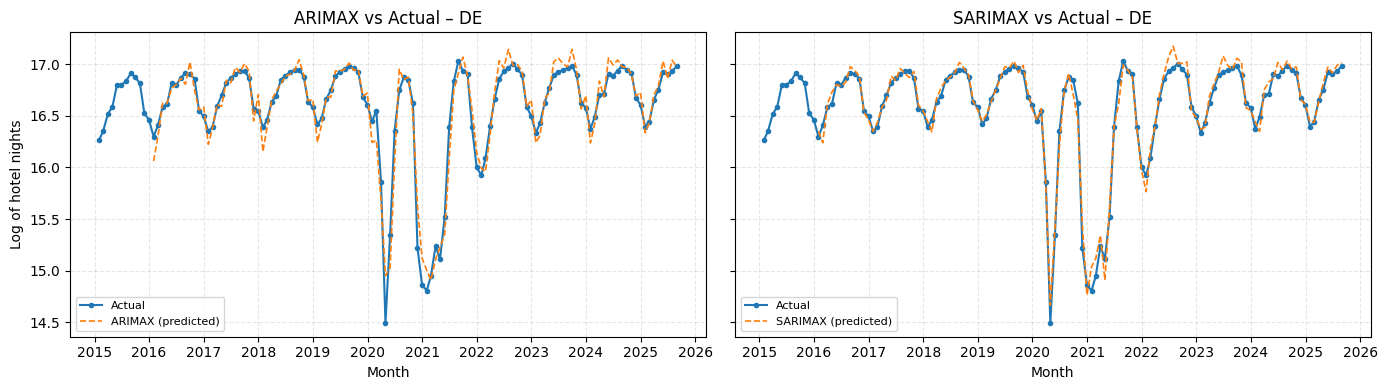

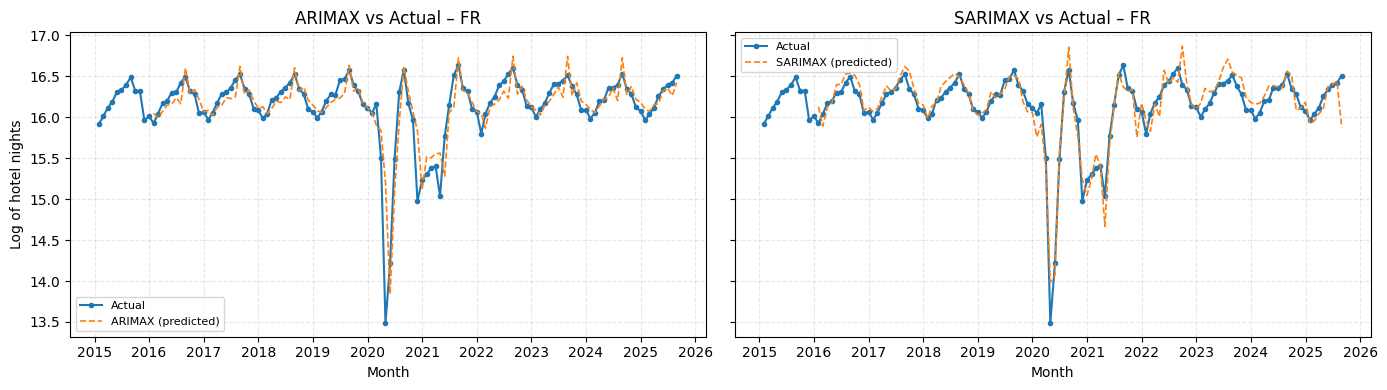

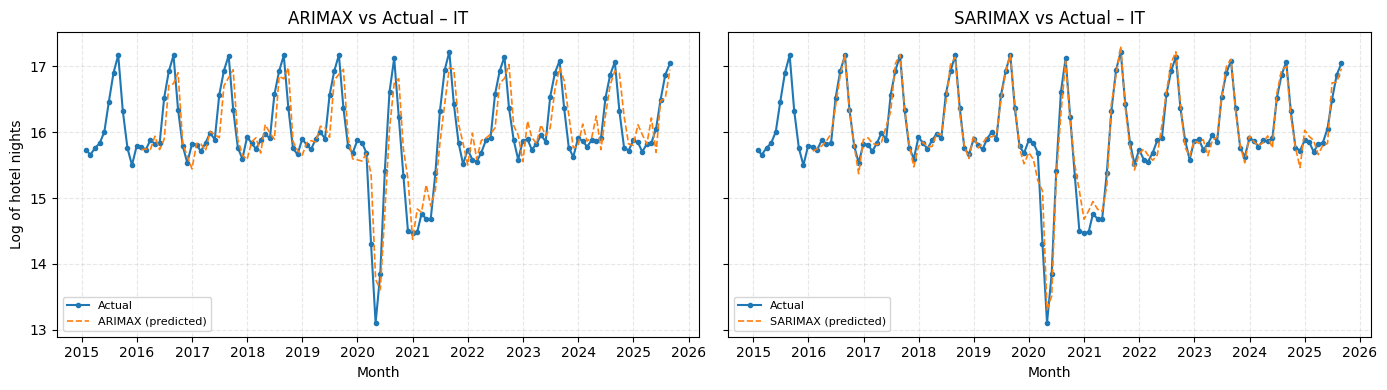

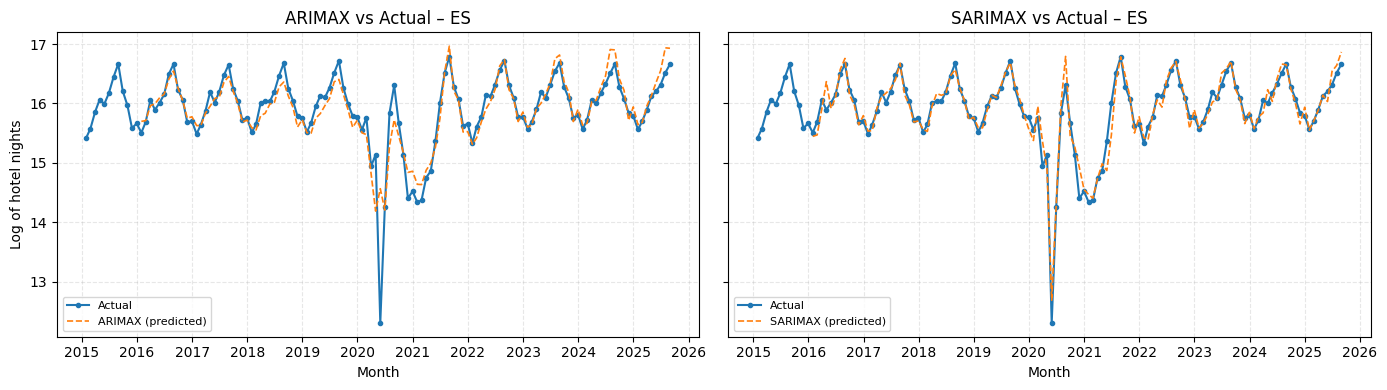

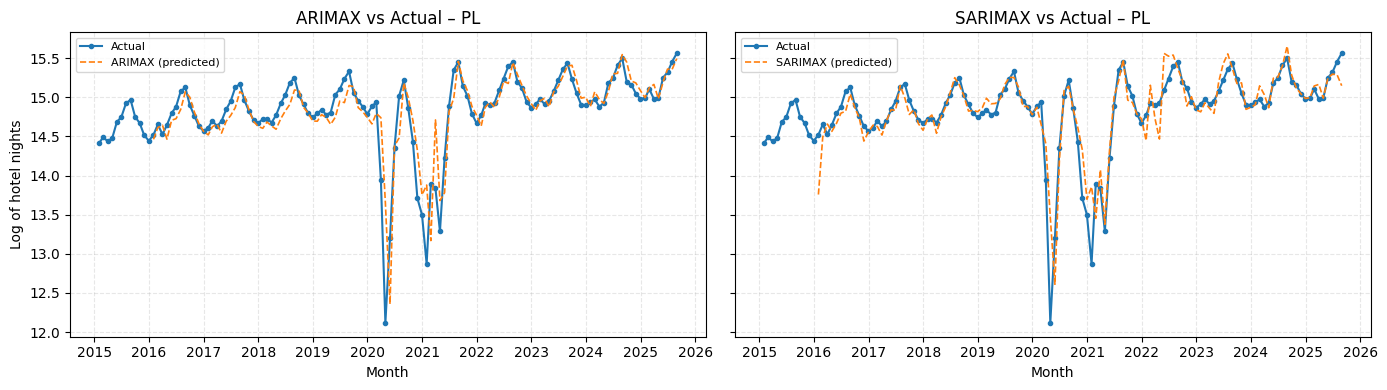

In [7]:
# %% ===============================================================
# STEP 6 — COMPARISON: ARIMAX vs SARIMAX (TOP 5 EU COUNTRIES)
# ===============================================================

PRED_PATH = DATA_PROCESSED / "hotel_predictions.csv"

if PRED_PATH.exists():
    preds = pd.read_csv(PRED_PATH, parse_dates=["month"])
    preds = preds[["region", "month", "yhat_arimax", "yhat_sarimax"]].drop_duplicates(subset=["region", "month"])
    df = df.drop(columns=["yhat_arimax", "yhat_sarimax"], errors="ignore")
    df = df.merge(preds, on=["region", "month"], how="left", validate="m:1")
    print(f"[INFO] Added ARIMAX & SARIMAX predictions from {PRED_PATH.name}")
else:
    print("[WARN] hotel_predictions.csv not found — check path.")

top_regions = (
    df.groupby("region")["log_nights_spent"]
      .mean()
      .nlargest(5)
      .index
      .tolist()
)
print(f"[INFO] Plotting ARIMAX vs SARIMAX for: {top_regions}")

compare_econometric_models(df, top_regions)

In [8]:
# %% ===============================================================
# PART 2 — MACHINE LEARNING MODELS (XGBOOST + LIGHTGBM)
# ===============================================================


# %% ===============================================================
# STEP 7 — GLOBAL ML MODELS (XGB & LGBM)
# Purpose: Train global pipelines (shared preprocessor), save, predict
# ===============================================================

np.random.seed(42)

X_train = train[cat_cols + num_cols]
y_train = train[target]
X_valid = valid[cat_cols + num_cols]

# XGB
pipe_xgb = train_global_pipeline(X_train, y_train, cat_cols, num_cols, model_type="xgb")
joblib.dump(pipe_xgb, MODELS / "pipe_xgb.pkl")
valid["yhat_xgb"] = predict_with_pipeline(pipe_xgb, X_valid)

# LGBM (global)
pipe_lgbm = train_global_pipeline(X_train, y_train, cat_cols, num_cols, model_type="lgbm")
joblib.dump(pipe_lgbm, MODELS / "pipe_lgbm.pkl")
valid["yhat_lgbm_global"] = predict_with_pipeline(pipe_lgbm, X_valid)

print("✅ Global ML pipelines trained and saved.")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4153
[LightGBM] [Info] Number of data points in the train set: 2808, number of used features: 53
[LightGBM] [Info] Start training from score 13.403345
✅ Global ML pipelines trained and saved.


In [9]:
# %% ===============================================================
# STEP 8 — SAVE MASTER PREDICTIONS
# Purpose: write/update data/processed/hotel_predictions.csv with all yhat_*
# ===============================================================
out_path = DATA_PROCESSED / "hotel_predictions.csv"
base = pd.read_csv(out_path, parse_dates=["month"]) if out_path.exists() else df.copy()

# Merge in XGB + (global) LGBM valid preds
base = base.drop(columns=["yhat_xgb","yhat_lgbm_global"], errors="ignore").merge(
    valid[["region","month","yhat_xgb","yhat_lgbm_global"]],
    on=["region","month"], how="left"
)
# Keep yhat_lgbm as the region-ensemble (if present); otherwise fall back to global
if "yhat_lgbm" not in base.columns:
    base = base.rename(columns={"yhat_lgbm_global":"yhat_lgbm"})
else:
    base["yhat_lgbm"] = base["yhat_lgbm"].fillna(base["yhat_lgbm_global"])
    base = base.drop(columns=["yhat_lgbm_global"], errors="ignore")

base.to_csv(out_path, index=False)
print(f"✅ Updated hotel_predictions.csv saved → {out_path.resolve()}")

✅ Updated hotel_predictions.csv saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/data/processed/hotel_predictions.csv


✅ Refreshed df with 3328 prediction records from hotel_predictions.csv
📊 Mean RMSE / MAE / MAPE across all regions:
 RMSE_XGB     0.205
MAE_XGB      0.176
MAPE_XGB     1.311
RMSE_LGBM    0.225
MAE_LGBM     0.195
MAPE_LGBM    1.452
dtype: float64


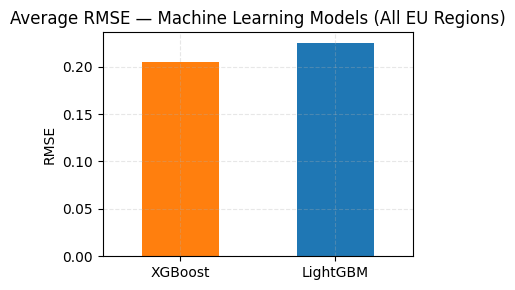

In [10]:
# %% ===============================================================
# STEP 9 — ML MODEL PERFORMANCE SUMMARY & VISUALIZATION
# Purpose: Compute XGBoost vs LightGBM metrics (RMSE / MAE / MAPE) and visualize results
# ===============================================================

pred_path = DATA_PROCESSED / "hotel_predictions.csv"

if pred_path.exists():
    preds = pd.read_csv(pred_path, parse_dates=["month"])
    preds = preds[["region", "month", "yhat_xgb", "yhat_lgbm"]]
    df = df.drop(columns=["yhat_xgb", "yhat_lgbm"], errors="ignore").merge(
        preds, on=["region", "month"], how="left"
    )
    print(f"✅ Refreshed df with {len(preds)} prediction records from hotel_predictions.csv")
else:
    print("⚠️ Warning: hotel_predictions.csv not found. Run previous step first.")

# --- Refresh valid subset with new predictions ---
valid = df[(df["month"] >= "2024-01-01") & (df["month"] < "2025-01-01")].copy()

# --- Compute per-region metrics using shared functions ---
eval_ml = (
    valid.groupby("region", group_keys=False)
    .apply(lambda d: pd.Series({
        "RMSE_XGB": rmse(d[target], d["yhat_xgb"]),
        "MAE_XGB":  mae(d[target], d["yhat_xgb"]),
        "MAPE_XGB": mape(d[target], d["yhat_xgb"]),
        "RMSE_LGBM": rmse(d[target], d["yhat_lgbm"]),
        "MAE_LGBM":  mae(d[target], d["yhat_lgbm"]),
        "MAPE_LGBM": mape(d[target], d["yhat_lgbm"]),
    }))
    .reset_index()
)

# --- Display summary table ---
print("📊 Mean RMSE / MAE / MAPE across all regions:\n",
      eval_ml.mean(numeric_only=True).round(3))

# --- Prepare mean RMSE values for visualization ---
mean_metrics_ml = eval_ml.mean(numeric_only=True).round(3)
rmse_ml = pd.Series({
    "XGBoost": mean_metrics_ml["RMSE_XGB"],
    "LightGBM": mean_metrics_ml["RMSE_LGBM"]
})
best_ml = rmse_ml.idxmin()
colors_ml = ["tab:blue" if m != best_ml else "tab:orange" for m in rmse_ml.index]

# --- Plot ---
plt.rcdefaults()
plt.figure(figsize=(4, 3))
rmse_ml.plot.bar(color=colors_ml)
plt.title("Average RMSE — Machine Learning Models (All EU Regions)")
plt.ylabel("RMSE")
plt.xticks(rotation=0)
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

[INFO] Plotting ML forecasts for: ['DE', 'FR', 'IT', 'ES', 'PL']


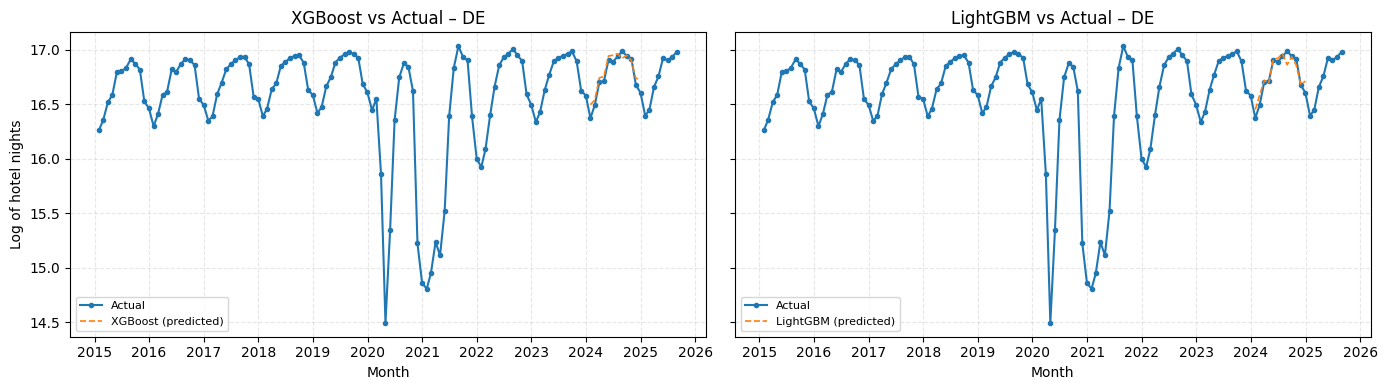

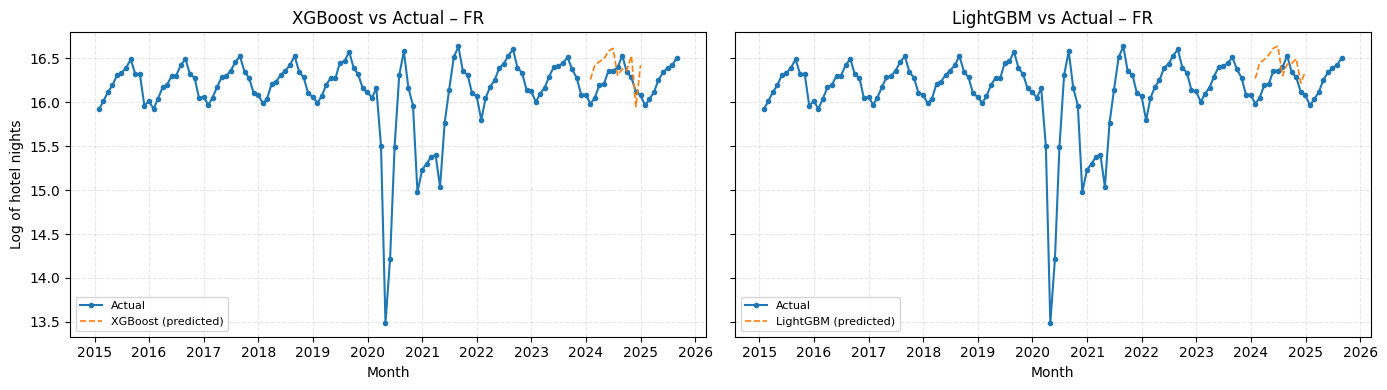

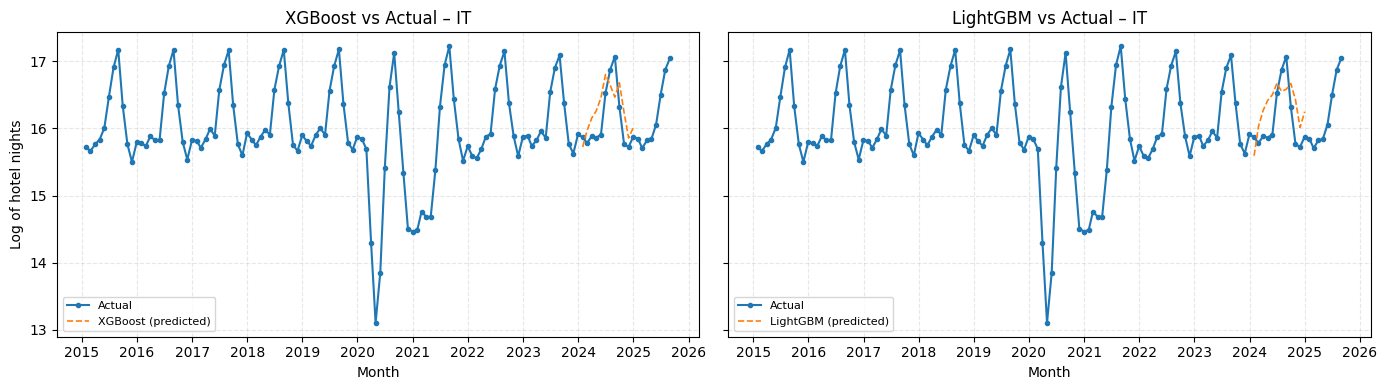

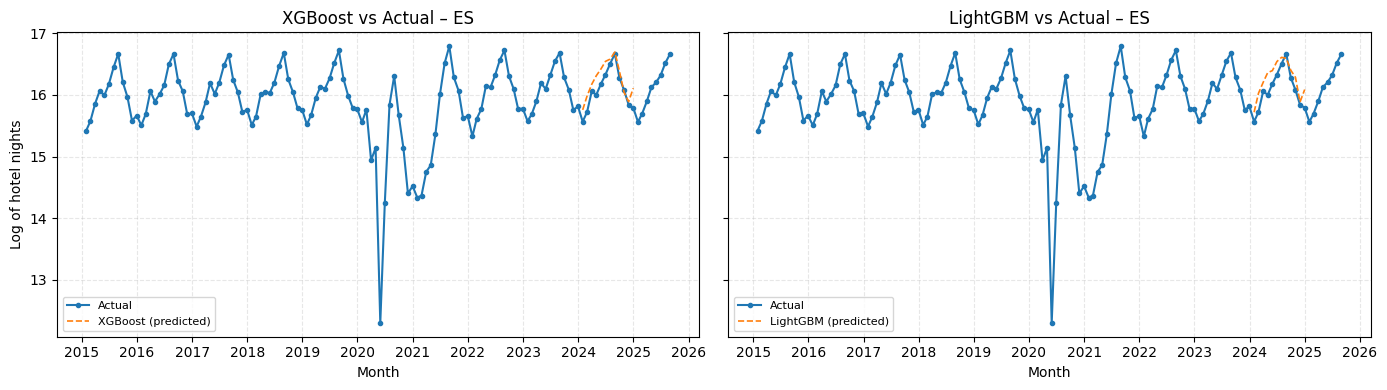

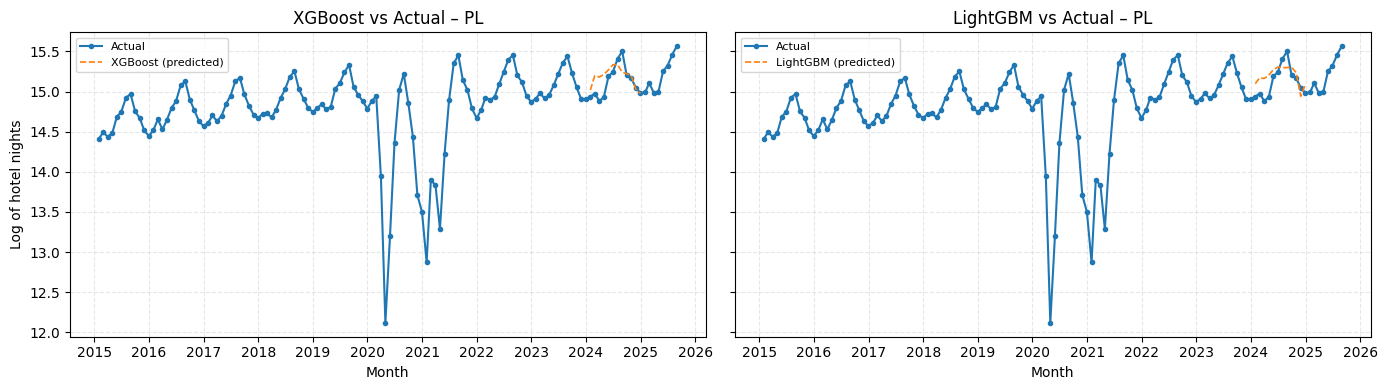

In [11]:
# %% ===============================================================
# STEP 10 — VISUALIZE XGBOOST AND LIGHTGBM FORECASTS - TOP 5 COUNTRIES
# ===============================================================

top_regions = (
    df.groupby("region")["log_nights_spent"]
      .mean()
      .nlargest(5)
      .index
      .tolist()
)
print(f"[INFO] Plotting ML forecasts for: {top_regions}")

compare_ml_models(df, top_regions)

In [12]:
# %% ===============================================================
# STEP 11 — SAVE TRANSFORMED SHAP MATRIX (FOR XGB/LGBM)
# Purpose: persist the transformed design matrix + feature names
# ===============================================================

preprocessor = pipe_xgb.named_steps["pre"]
X_train_transformed = preprocessor.transform(X_train)

try:
    feature_names = preprocessor.get_feature_names_out()
except Exception:
    cat_encoder = preprocessor.named_transformers_["cat"]
    if hasattr(cat_encoder, "get_feature_names_out"):
        cat_features = cat_encoder.get_feature_names_out(["region"])
    else:
        cat_features = cat_encoder.get_feature_names(["region"])
    num_features = [c for c in X_train.columns if c not in ["region"]]
    feature_names = np.concatenate([cat_features, num_features])

if X_train_transformed.shape[1] != len(feature_names):
    print(f"⚠️ Feature mismatch: transformed={X_train_transformed.shape[1]}, names={len(feature_names)}")
    feature_names = [f"f{i}" for i in range(X_train_transformed.shape[1])]
    print("🩹 Fallback: generated generic feature names.")

X_train_shap = pd.DataFrame(X_train_transformed, columns=feature_names, index=X_train.index)
X_train_shap.to_parquet(MODELS / "X_train_shap.parquet")

with open(MODELS / "X_train_columns.json", "w") as f:
    json.dump(list(feature_names), f)

print(f"✅ SHAP matrix saved: {X_train_shap.shape[0]} rows × {X_train_shap.shape[1]} features")

✅ SHAP matrix saved: 2808 rows × 53 features


## ✅ Summary

Notebook 3 completed successfully.  
All econometric (ARIMAX, SARIMAX) and machine learning (XGBoost, LightGBM) models were trained, compared, and saved.  
The final prediction dataset integrates all forecasts and is ready for interpretability and economic analysis in **Notebook 4 — Model Interpretability and Economic Drivers of Hotel Demand (2015–2026)**.

---
